In [1]:
# ========================
#  Customer Segmentation
# ========================

# Load data:
import pandas as pd

df = pd.read_csv("/home/khanhan/Desktop/DataMiningPython/data.csv", encoding='cp1252')

# Customer by country:
df_con = df['Country'].value_counts()

# Convert df_con to data frame:
df_con = df_con.reset_index()

# Some observations:
df_con.head()

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533


In [2]:
# Number of unique customers:
ID_unique = df['CustomerID'].unique().shape
print(ID_unique)

# Check negative values:
df['Quantity'].describe()

(4373,)


count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [3]:
df['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [4]:
# Remove negtive value:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Check again:
df['UnitPrice'].describe()

count    530104.000000
mean          3.907625
std          35.915681
min           0.001000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [5]:
# Remove missing data for CustomerID column:
df = df[df['CustomerID'].notnull()]

# Convert to date time for InvoiceDate:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check data type:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [8]:
# Convert to YMD data:
df['InvoiceDateYMD'] = df['InvoiceDate'].dt.to_period('d')

# Calculate monetary sale:
df['MonetarySale'] = df['UnitPrice'] * df['Quantity']

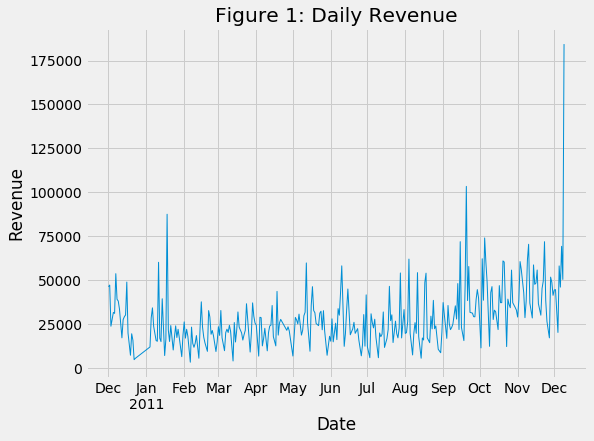

In [7]:
# Daily Revenue:
dailysaleMoney = df.groupby('InvoiceDateYMD')['MonetarySale'].sum()

# Plot daily revenue:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

dailysaleMoney.plot(lw=1, figsize=(8, 6))
plt.title("Figure 1: Daily Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

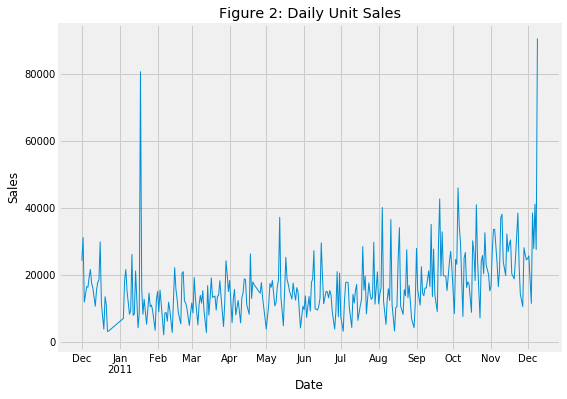

In [9]:
# Daily unit sales:
dailyUnitSale = df.groupby('InvoiceDateYMD')['Quantity'].sum()

# Plot daily unit sales:
dailyUnitSale.plot(lw=1, figsize=(8, 6))
plt.title("Figure 2: Daily Unit Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [10]:
# Calculate M:
df_monetary = df.groupby('CustomerID')['MonetarySale'].sum().reset_index()

# Calculate F:
df_freq = df['CustomerID'].value_counts().reset_index()
df_freq = df_freq.rename(columns={'index': 'CustomerID', 'CustomerID': 'Freq'})

In [11]:
# Calculate R:
df['DiffDays'] = (df['InvoiceDate'].max() - df['InvoiceDate']).astype('timedelta64[D]')
df_recency = df.groupby('CustomerID')['DiffDays'].min().reset_index()

# Rename for column:
df_recency.columns = ['CustomerID', 'recency']

# Merge data:
df_rm = pd.merge(df_recency, df_monetary, on='CustomerID')

# Final RFM data for clustering algorithm:
df_rfm = pd.merge(df_rm, df_freq, on='CustomerID')

# Some observations: 
df_rfm.head()

,CustomerID,recency,MonetarySale,Freq
0,12346.0,325.0,77183.60,1
1,12347.0,1.0,4310.00,182
2,12348.0,74.0,1797.24,31
3,12349.0,18.0,1757.55,73
4,12350.0,309.0,334.40,17


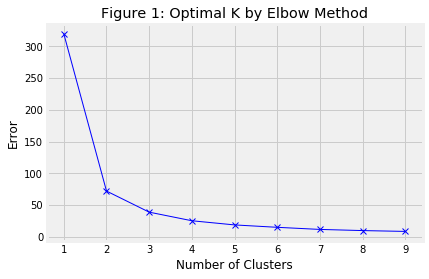

In [12]:
# ================================
# K-means Clustering Algorithm
# ================================

# Features for clustering:
X = df_rfm.drop('CustomerID', axis=1)

# Normalize data:
from sklearn.preprocessing import MinMaxScaler

my_scale = MinMaxScaler()
my_scale.fit(X)
X_scaled = my_scale.transform(X)

# Instantiate k-means cluster:
from sklearn.cluster import KMeans

# Eelbow method of selecting optimal K:

Error = []
clusters = range(1, 10)

for i in clusters:
    kmeans = KMeans(n_clusters=i).fit(X_scaled)
    kmeans.fit(X_scaled)
    Error.append(kmeans.inertia_)

# Cluster - Error curve::
plt.plot(clusters, Error, 'bx-', lw=1)
plt.title('Figure 1: Optimal K by Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Error')
plt.show()

In [13]:
# Conduct K-means Clustering with k = 3:
kmean3 = KMeans(n_clusters=3)
groups = kmean3.fit_predict(X_scaled)

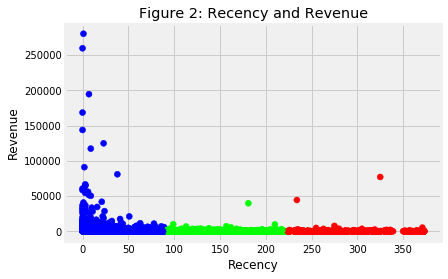

In [14]:
# Plot 2:
plt.scatter(df_rfm['recency'], df_rfm['MonetarySale'], c=groups, cmap='brg')
plt.title('Figure 2: Recency and Revenue')
plt.xlabel('Recency')
plt.ylabel('Revenue')
plt.show()

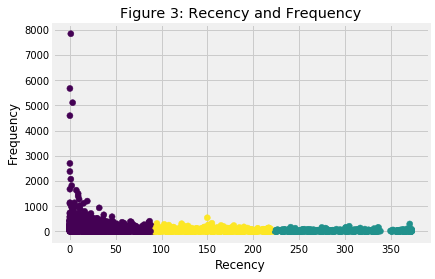

In [15]:
# Plot 3:
plt.scatter(df_rfm['recency'], df_rfm['Freq'], c=groups, cmap='viridis')
plt.title('Figure 3: Recency and Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Add label for customers:
df_rfm['Group'] = groups

# Some statistical characteristics by group:
df_rfm.drop('CustomerID', axis=1).groupby('Group').describe().transpose()

Group                           0             1             2
Freq         count    2906.000000    626.000000    806.000000
             mean      120.497591     23.688498     40.805211
             std       273.492710     27.821668     47.859686
             min         1.000000      1.000000      1.000000
             25%        27.000000      8.000000     12.000000
             50%        61.000000     16.000000     26.000000
             75%       134.000000     28.000000     52.000000
             max      7847.000000    297.000000    543.000000
MonetarySale count    2906.000000    626.000000    806.000000
             mean     2714.737276    607.195479    796.869741
             std     10759.960219   3584.565469   1668.783657
             min         6.200000      3.750000     15.000000
             25%       427.202500    155.555000    232.755000
             50%       984.740000    289.565000    459.995000
             75%      2273.555000    435.517500    898.625000
             max    280206.020000  77183.600000  39916.500000
recency      count    2906.000000    626.000000    806.000000
             mean       31.163799    293.431310    152.400744
             std        25.089417     45.109849     38.405673
             min         0.000000    224.000000     92.000000
             25%        10.000000    256.000000    118.000000
             50%        24.000000    286.500000    151.500000
             75%        50.000000    325.750000    185.000000
             max        91.000000    373.000000    222.000000

In [17]:
# Revenue by group:
revenueGroup = df_rfm.groupby('Group')['MonetarySale'].sum().reset_index()
revenueGroup['RevPercent'] = revenueGroup['MonetarySale'] / sum(revenueGroup['MonetarySale'])
print(revenueGroup)

   Group  MonetarySale  RevPercent
0      0   7889026.523    0.885273
1      1    380104.370    0.042654
2      2    642277.011    0.072074
